In [132]:
import warnings
warnings.filterwarnings("ignore")

import re
import string
import pandas as pd
import numpy as np
import emoji
import unicodedata
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora, models
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.decomposition import PCA

In [133]:
df = pd.read_csv('data.csv')
df

,full_text,case_folding CPMK2,preprocessing CPMK3
0,yeay naik secret elshark gran maja 1/4m pulau ...,yeay naik secret elshark gran maja 1/4m pulau ...,yeay secret elshark gran maja pulau pulang mar...
1,semenjak kenal fish aku melupakan gunung,semenjak kenal fish aku melupakan gunung,kenal lupa gunung
2,koin fish via mitos https //t.co/f6ciorza2r,koin fish via mitos https //t.co/f6ciorza2r,koin via mitos ciorza
3,baru banget aku main fish semalam langsung keb...,baru banget aku main fish semalam langsung keb...,main malam langsung bawa mimpi anjing
4,ruonadn bilubelii kalah sama fish,ruonadn bilubelii kalah sama fish,ruonadn bilubeli kalah
...,...,...,...
1365,kayanya langganan red finger gue abis gue pens...,kayanya langganan red finger gue abis gue pens...,kaya langanan red finger habis pensiun gila se...
1366,tomioka67827909 betul sekali main fish biar bi...,tomioka67827909 betul sekali main fish biar bi...,tomioka main away from keyboard tarik joran bener
1367,sudah tahap muak banget main fish tapi kraken ...,sudah tahap muak banget main fish tapi kraken ...,tahap muak main kraken angkat
1368,temen-temenku sudah makin banyak yang main fis...,temen-temenku sudah makin banyak yang main fis...,teman teman aku main sat


In [134]:
df.drop_duplicates(subset="full_text", inplace=True)
df.dropna(subset=["full_text"], inplace=True)
df

,full_text,case_folding CPMK2,preprocessing CPMK3
0,yeay naik secret elshark gran maja 1/4m pulau ...,yeay naik secret elshark gran maja 1/4m pulau ...,yeay secret elshark gran maja pulau pulang mar...
1,semenjak kenal fish aku melupakan gunung,semenjak kenal fish aku melupakan gunung,kenal lupa gunung
2,koin fish via mitos https //t.co/f6ciorza2r,koin fish via mitos https //t.co/f6ciorza2r,koin via mitos ciorza
3,baru banget aku main fish semalam langsung keb...,baru banget aku main fish semalam langsung keb...,main malam langsung bawa mimpi anjing
4,ruonadn bilubelii kalah sama fish,ruonadn bilubelii kalah sama fish,ruonadn bilubeli kalah
...,...,...,...
1365,kayanya langganan red finger gue abis gue pens...,kayanya langganan red finger gue abis gue pens...,kaya langanan red finger habis pensiun gila se...
1366,tomioka67827909 betul sekali main fish biar bi...,tomioka67827909 betul sekali main fish biar bi...,tomioka main away from keyboard tarik joran bener
1367,sudah tahap muak banget main fish tapi kraken ...,sudah tahap muak banget main fish tapi kraken ...,tahap muak main kraken angkat
1368,temen-temenku sudah makin banyak yang main fis...,temen-temenku sudah makin banyak yang main fis...,teman teman aku main sat


<h>PREPOCESSING</h>

In [135]:
# Daftar kata kunci relevan dan tidak relevan untuk Fish It
topic_keywords = [
    "fish it", "fishit", "fishing", "roblox", "fish", "rod", "bait", "boat", "merchant",
    "secret", "ancient whale", "megalodon", "island", "jungle", "coral reef", "stingray shores",
    "kohana", "mutation", "shiny", "potion", "luck", "enchant", "battlepass", "admin event",
    "halloween event", "update", "f2p", "skin", "crab", "lobster"
]

irrelevant_keywords = [
    "download", "promo", "iklan", "klik link", "aplikasi", "follow", 
    "giveaway", "voucher", "diskon", "gratis", "registrasi", "daftar", "event", "joki"
]

# Fungsi untuk mengecek relevansi
def is_relevant(text):
    text_lower = text.lower()
    if any(bad in text_lower for bad in irrelevant_keywords):
        return False
    return any(topic in text_lower for topic in topic_keywords)

# Load data dari data.csv
df = pd.read_csv("data.csv")

# Langkah 1: Hapus duplikat berdasarkan teks asli
df = df.drop_duplicates(subset="full_text").reset_index(drop=True)

# Langkah 2: Filter data relevan
mask = df["full_text"].astype(str).apply(is_relevant)
df = df[mask].reset_index(drop=True)

# Simpan teks yang sudah difilter
texts = df["full_text"].astype(str)

# Cetak jumlah data setelah deduplikasi dan pembersihan topik
print(f"Jumlah data setelah deduplikasi dan pembersihan topik: {len(df)} baris tersisa.")

Jumlah data setelah deduplikasi dan pembersihan topik: 1370 baris tersisa.


In [136]:
# --- STOPWORD & STEMMER ---
stop_factory = StopWordRemoverFactory()
stop_sastrawi = set(stop_factory.get_stop_words())
stop_nltk = set(stopwords.words('indonesian'))

# Tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# --- TAMBAH STOPWORD GAUL & UMUM (TAMBAH KOMA!) ---
manual_stopwords = {
    'aku', 'nya', 'oke', 'aja', 'saya', 'sih', 'doang', 'gw', 'gua', 'aq', 
    'kamu', 'lu', 'loe', 'km', 'kmu', 'iya', 'ya', 'yah', 'nih', 'dong', 
    'lah', 'kah', 'deh', 'ajah', 'aj', 'gak', 'ga', 'gk', 'ngga', 'tp', 
    'tpi', 'sm', 'sma', 'lg', 'lgi', 'udh', 'udah', 'dah', 'blm', 'blom',
    'klo', 'kalo', 'kl', 'gt', 'gtu', 'gini', 'gmn', 'gimana', 'wkwk', 
    'haha', 'hehe', 'huhu', 'anjir', 'bjir', 'cok', 'coy', 
    'dm', 'btw', 'pls', 'plis', 'brp', 'brpa', 'kak', 'bang', 'bro', 
    'sis', 'pun', 'mah', 'tu', 'nih', 'https', 'http', 'www', 'co', 
    'id', 'net', 'org', 'yuk', 'ken', "gue", "guys", "tau", "tuh", "daki",
    "biar", "kali", "banget", 'mending', 'gitu', "kakak", "pas", "karena",
    "ayo", "semoga", "kena", "ajaa", "gara gara", "sender", "gara", "pake", 
    "emang", "txtfromroblox", "by the way", "karna", "avqris avrekber okii", "ptpt",
    "gais", "teman teman", "abang", "ges", "sejak", "wprs", "wxs", "jdi", "hxds",
    "fiy", "goqfbdbk", "abng", "slu", "halo", "wel", "pdbufdwhqu", "woi", "wkw", "wkwkw",
    "huh", "tirant", "kayak", "blio", "adt", "hxdx", "lainkau", "mai","krn","mots",
    "huhuhu","trus","deyzwn","wkwkwkwk","hahahaha","bye","nti","wavetoana","mod","bgitu",
    "mas","gusy","pgn", "sok","nvk","kykbta","fdofknz","nge","gais","apasih","tkhb",
    "guis","textdaricrispy","oalah","ges","kmrxbgs", "letsgo", "dung","arow","zsqcwyxwor",
    "alo","eubr","mzs","cfw","gusy","znxg","ges","ayfy","kie","mfxcu","itbrwnpbig","sar",
    "prmblvjfwr","hai","sblm","cbxulmqlgb","owejxclj","hrgvd","pic","hqtb", "tws","isayanglain",""
    "gwa","kirain","journtales","kayak","cihuy","iyain","sed","sia","rikipan","indtc","ape","dih",
    "nge","aje","gweh","bud","kewel","uing","hel","starjemina","tung","yak","chinchila","gweh","kep",
    "dund","fian", "gbs", "hft", "kyknya", "aing","wdo","yeagerisr","tinixtus",
    "jayantieys","danjeurs","lalanyimud","ryls", "gbkal","yeolmbuy","saf","kwjfpc","mtuanblox","jgyn"






}

# --- KATA KUNCI FISH IT (JANGAN DIHAPUS!) ---
topic_keywords = {
    'fish', 'secret', 'kraken', 'megalodon', 'afk', 'mancing', 'pancingan',
    'trade', 'enchant', 'zona', 'uang', 'mitos', 'roblox', 'server', 'luck',
    'talon', 'potion', 'shiny', 'mutation', 'boat', 'bait', 'merchant',
    'island', 'jungle', 'coral', 'stingray', 'kohana', 'shores', 'battlepass',
    'halloween', 'update', 'f2p', 'skin', 'crab', 'lobster'
}

# --- GABUNG STOPWORD ---
stop_words = (stop_nltk.union(stop_sastrawi).union(manual_stopwords)) - topic_keywords

# --- STEMMER ---
stemmer = StemmerFactory().create_stemmer()

In [137]:
def case_folding(text):
    text = text.lower()
    return text

# Kamus untuk perbaikan typo, singkatan
corrections = {
    # Gaul umum (dari kode asli + tambah)
    "anjir": "anjing", "anjg": "anjing", "anj": "anjing", "jir": "anjing", "bjir": "anjing", "ajg": "anjing", "anjay": "anjing",
    "wtf": "apa", "lol": "tertawa", "wkwk": "tertawa", "wkwkwk": "tertawa", "haha": "tertawa", "hahaha": "tertawa", "hehe": "tertawa",
    "gw": "gue", "gua": "gue",  "ak": "aku", "aq": "aku", "ku": "aku", "lu": "kamu", "loe": "kamu", "km": "kamu", "kmu": "kamu",
    "gak": "tidak", "ga": "tidak", "gk": "tidak", "ngga": "tidak", "bgt": "banget", "bgtt": "banget", "bngt": "banget",
    "tp": "tapi", "tpi": "tapi", "sm": "sama", "sma": "sama", "lg": "lagi", "lgi": "lagi", "udh": "sudah", "udah": "sudah", "dah": "sudah",
    "blm": "belum", "blom": "belum", "bkn": "bukan", "klo": "kalau", "kalo": "kalau", "kl": "kalau", "aj": "aja",
    "dapet": "dapat", "dpt": "dapat", "dpet": "dapat", "daper": "dapat", "dptn": "dapat", "pancingan": "pancing", "pancingn": "pancingan",
    "menginap": "inap", "maleman": "malam", "bjil": "anjing", "ngestuck": "stuck",
    "afk": "away from keyboard", "gess": "guys", "uhuy": "uhuy", "shibaal": "sial", "gamood": "gamau", "fagh": "fuck",
    "mulu": "terus", "blom": "belum", "juseyo": "tolong", "wangi": "bagus", "aowkowwkok": "tertawa",
    "redfinger": "redfinger", "betmut": "batas mutu", "hcketawa": "tertawa", "kaga": "tidak",
    "semalem": "semalam", "btw": "by the way", "grub": "group", "ngebug": "bug", "makas": "terima kasih", "makasi": "terima kasih",
    "gosrek": "ghost shark", "rill": "real", "kinyis": "kinclong", "mr": "mister", "diH": "dih", 
    "sung": "langsung", "leavs": "leave", "nambahin": "menambah", "org": "orang", "dpt":"dapat", "org":"orang",
    "eso": "esoteric", "uhuy": "senang", "somnong": "sombong", "mahh": "iya", "bro": "kamu", "utk": "untuk", 
    "bang": "kakak", "sht": "shit", "amp": "dan", "sllu": "selalu", "prtma": "pertama", "rsanya": "rasa", "well": "senang",
    "ktnya": "katanya", "bru": "baru", "bbrpa": "beberapa", "kcnduan": "kecanduan", "ternyta": "ternyata",
    "ssru": "seru", "kai": "kai", "kasih": "berikan", "belom": "belum", "uda": "sudah", "sepulau": "sepulau", "suruh": "disuruh",
    "ginian": "begini", "kotoran": "kotoran", "keknya": "kayaknya", "arung": "mengarungi", "shibaal": "sial", "dah": "sudah", "gamood": "gamau", "fagh": "fuck", "krna": "karena",
    "sinta": "sinta", "open": "open", "grgr": "gara-gara", "ancient": "ancient", "jungle": "jungle", "susah": "susah",
    "bangun": "bangun", "tidur": "tidur", "senagih": "se-nagih", "meledakk": "meledak", 
    "males": "malas",  "engga": "tidak",  "openk": "open", "yuu": "ajak", "nyang": "yang", "bobak": "coba", "gempass": "gamepass",
    "gag": "tidak", "timsar": "timsar", "kelipat": "kelipatan","ettoilest": "ettoilest",
    "waifue": "waife", "knp": "kenapa", "gabisa": "tidak bisa", "pancong": "pancong", "indopopbase": "indo pop base", "narkoboy": "narkoba", "brsm": "bersama", "letjungcook": "lee jungkook",
    "bnr": "benar", "bcs": "karena", "riweuh": "ribet", "bulak": "bolak", "makasihh": "terima kasih", "kakk": "kak", "jga": "juga", "terjun": "terjun", "dikerjain": "dikerjain", "tanggung": "bertanggung jawab",
    "plhiv": "plhiv", "here": "di sini", "makan": "makan", "oil": "oil", "take": "ambil", "ganggu": "ganggu", "ubat": "obat",
    "jap": "sebentar", "takda": "tidak ada",  "number": "nomor", "opang": "opang", "gaa": "tidak",
    "grinding": "grinding", "tinggal": "tinggal", "scroll": "scroll", "tiktok": "tiktok", "nemu": "nemu", "live": "live",
    "aji": "pengajian", "tolak": "bertolak belakang", "cung": "cung", "kerja": "kerja", "sambil": "sambil", "anjing": "anjing",
    "diem": "diam", "gausa": "tidak usah", "ucup": "ucup", "org": "orang", "limit": "limit", "astaghfirullah": "astaghfirullah",
    "mula": "pemula", "volcano": "volcano", "salpok": "salpok", "abang": "abang", "batu": "batu", "pusing": "pusing",
    "ninggalin": "meninggalkan", "kli": "kali", "gass": "gas", "acc": "account", "yhh": "ya", "cisi": "cici",
    "cuman": "cuma", "gegara": "gara-gara", "ken": "ingin", "pen" : "ingin", "memberr": "member", "truss": "terus",
    "maen": "main", "baruu": "baru", "rep": "reply", "dm": "direct message",
    "liat": "lihat", "oon": "bodoh", "grgr": "gara-gara", 'mulu':"terus", 'wib':'waktu indonesia barat', "nyari":"cari", "jgn":'tidak', "emg":"memang", "tertawa":"tawa", "nyoba":"coba", "gara gara" :"karena",
    'moga':'semoga', 'gamau':'tidak', 'temen':'teman','bikin':'buat','nanya':'tanya', 'biar':'karena', "mancing":"pancing", "info":"informasi", "pake":"pakai", "narik":"tarik", "letsgoo":"ayo", "ngangkat":"angkat",
    "abis":'habis', "dece": "discord", "rame":"ramai", "adain":"ada", "nyalain":"nyala", "temenku":"teman aku", "orng":"orang", "ngajak":"ajak", "bener":"benar", "nongkrong":"tongkrong",
    "ikannya":"ikan", "beneran":"benar", "ajarin":"ajar", "nambah":"tambah", "naf":"maaf", "semenjak":"sejak", "roblok":"roblox", "rosblok":"roblox",
    "jdi":"jadi", "tetep":"tetap","dapatin":"dapat", "ngelawak":"lawak", "ditinggal":"tinggal",
    "ilang":"hilang", "ngoceh":"bicara", "ketemu":"temu", "nungguin":"tunggu", "updatean":"update", "semenjak":"sejak",
    "rbx":"robux", "oohsyit":"anjing", "enga":"tidak", "nyamain":"sama", "deym":"anjing", "gapapa":"tidak",
    "salfok": "salah paham", "ledaknya":"ledak", "ledeknya":"ledek", "nyangka":"sangka", "bosen":"bosan",
    "maf":"maaf", "gamod":"sebal","plish":"tolong","indo":"indonesia","ngak":"tidak","orngnya":"orang","perhatin":"hati","hayuk":"ajak","judol":"judi online","shibal":"anjing","usn":"username",
    "nagih":"tagih","mingu":"minggu","tres":"stres","mancingnya":"pancing","meninggalkan":"tinggal","cepet":"cepat","pengangguran":"anggur","drpd":"daripada", "sru":"seru", "ngantuk":"kantuk",
    "digift":"gift","pov":"point of view","boking":"pesan","ketentuannya":"ketentuan","ngasi":"kasih","sekret":"secret",
    "yaping":"bicara","marahin":"marah","free":"kosong","apasih":"apa","krh":"keruh","serv":"server","ngebost":"bost","naikin":"naik","macem":"macam","deketin":"dekat","njir":"anjing","anjins":"anjing",
    "ama":"sama","kit":"sakit","ngecek":"cek","sebel":"sebal","serfer":"server","mikir":"pikir", "ptpt":"patung",
    "kemaren":"kemarin", "cod":"cash on delivery","ditumbalin":"tumbal","ngiler":"iler","kegacoran":"bagus","rekber":"rekening bersama",
    "gausah":"tidak","kawannya":"teman","kelipat":"lipat","kawan":"teman","resp":"respon","slowresp":"slow respon","datapolos":"data polos","bobuk":"robux",
    "imup":"imut","gempas":"gamepass","komun":"komunitas","secretnya":"secret","listnya":"list","nunggu":"tunggu","murce":"murah","bes":"teman","nyusul":"susul","item":"hitam",
    "gacor":"bagus","ngekost":"kost", "malem":"malam", "gblok":"anjing","lebay":"aneh","ratenya":"rate","nonstop":"non stop","ngeleg":"lag","relaxing":"relax",
    "nyebelin":"sebal","ngobrol":"bicara","ngeluhin":"keluh","ngerasa":"rasa","kgk":"tidak","anying":"anjing","ngelist":"list","sebenernya":"benar",
    "relaxingnya":"relax","samain":"sama","ogah":"tidak","ftogame":"foto game","perbandingannya":"banding","playwithmot":"main","bay":"pamit",
    "uwong":"orang","sorygaklevel":"sorry tidak level","dipake":"pake","rosblok":"roblox","denger":"dengar","koinnya":"koin","selesein":"selesai","gawe":"bekerja",
    "improving":"improve","ngeluarin":"keluar","begadang":"gadang","ngaruhin":"aruh","beneran":"bener","ngebosenin":"bosan","kagak":"tidak","dewe":"sendiri","kemaren":"kemarin",
    "pershu":"suhu","suda":"susah","seng":"sayang","ningalin":"tinggal", "ditinggalin":"tinggal", "ngantukan":"kantuk", "fomo":"ikut",
    "omak":"kaget", "malak":"palak", "bacot":"banyak bicara", "playwithmoy":"main", "perbandinganyua":"banding", "ngasih":"kasih", "owhsyit":"anjing", "owhsyhit":"anjing",
    "kawanya":"teman", "onmic":"on mic", "robaks":"robux", "udahan":"sudah", "bangsat":"anjing", "avatarnya":"ava","lgsng":"langsung",
    "lgsg":"langsung","orgil":"orang gila","ditingal":"tinggal","yap":"benar","samsek":"sama sekali","ngeh":"benar","sbelah":"sebelah",
    "wakaka":"lucu","alah":"lucu","ngapa":"tanya","gamenya":"game","bodoamat":"tidak peduli","lampiasin":"kesal","nyerah":"tidak mampu","flwr":"follower","gong":"kaget",
    "ngapain":"tanya","ngajakin":"ajak","gatau":"tidak paham","dapetin":"dapet","dikatain":"kata","ngepush":"push","nyampe":"sampai","tman":"teman","tbtb":"langsung",
    "wlaupun":"walaupun","orgorg":"orang", "brengsek":"anjing","nyandu":"candu","gapernah":"tidak pernah","gkdapet":"tidak dapat",
    "outfitnya":"outfit","hasmat":"hazmat","takedown":"take down","milih":"pilih","keitung":"hitung","digodain":"goda","goalsku":"goals","kbnyakan":"banyak","gmw":"tidak",
    "pdhal":"padahal","ngejar":"kejar","mainin":"main","robloks":"roblox","bejir":"anjing","inget":"ingat","nunguin":"tunggu","kripshit":"anjing"


    






}

gaul = {
    
}

In [138]:
def case_folding(text):
    text = text.lower()
    return text

df_new = pd.DataFrame({
    "full_text": texts,
    "case_folding": texts.apply(case_folding)
})

df_new.to_csv("data_casefolding.csv", index=False)

In [139]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b(fish it|fishit|fish|ikan|ikan itu|ikanitu)\b', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'http\S+|www\S+', ' ', text)     
    text = re.sub(r'@\w+', ' ', text)                
    text = emoji.demojize(text)                      
    text = re.sub(r'\d+', ' ', text)                 
    text = re.sub(r'[^\w\s]', ' ', text)             
    text = re.sub(r'(.)\1{2,}', r'\1', text)         
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r"http\S+|www\S+|bit\.ly/\S+", "", text)
    text = re.sub(r'(.)\1+', r'\1', text)
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"\brt\b", "", text)
    text = re.sub(r"[0-9]+", "", text)
    text = text.encode("ascii", "ignore").decode("ascii")
    text = re.sub(r"\s{2,}", " ", text).strip()         

    tokens = tokenizer.tokenize(text)

    tokens = [corrections.get(w, w) for w in tokens if w not in corrections or corrections[w] != ""]

    tokens = [token for token in tokens if len(token) >= 3]

    tokens = [w for w in tokens if w not in stop_words]

    tokens = [stemmer.stem(w) for w in tokens]

    return " ".join(tokens)

df["preprocessing"] = texts.apply(clean_text)

In [140]:
df_new = pd.DataFrame({
    "full_text": texts,
    "case_folding CPMK2": texts.apply(case_folding),
    "preprocessing CPMK3": df["preprocessing"]
})

df_new.to_csv("data.csv", index=False)

In [141]:
df["bersih"] = df["preprocessing"].apply(clean_text)
df['bersih']

0       yeay secret elshark gran maja pulau pulang pul...
1                                       kenal lupa gunung
2                                   koin via mitos ciorza
3                   main malam langsung bawa mimpi anjing
4                                  ruonadn bilubeli kalah
                              ...                        
1365    kaya langanan red finger habis pensiun gila se...
1366          tomioka main away from keyboard tarik joran
1367                        tahap muak main kraken angkat
1368                                 teman teman main sat
1369    dunia adil anjing orang ajakin main ngajarin k...
Name: bersih, Length: 1370, dtype: object

<h>KMEANS</h>

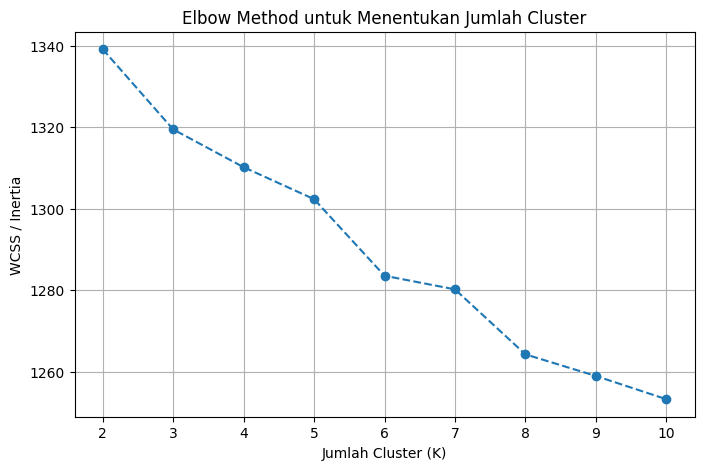


=== Jumlah K terbaik menurut Elbow Method: 5 ===


In [142]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=4500)
X = tfidf.fit_transform(df["bersih"])

# Fungsi Elbow (Automatic K)
def get_best_k_by_elbow(wcss_values):
    diff_1 = np.diff(wcss_values)
    diff_2 = np.diff(diff_1)
    best_k = np.argmax(diff_2) + 2
    return best_k

# Hitung WCSS
wcss = []
K = range(2, 11)

for k in K:
    model = KMeans(
        n_clusters=k,
        random_state=42,
        n_init="auto"
    )
    model.fit(X)
    wcss.append(model.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K, wcss, linestyle="--", marker="o")
plt.title("Elbow Method untuk Menentukan Jumlah Cluster")
plt.xlabel("Jumlah Cluster (K)")
plt.ylabel("WCSS / Inertia")
plt.grid(True)
plt.show()

# Menampilkan hasil K terbaik
best_k = get_best_k_by_elbow(wcss)
print(f"\n=== Jumlah K terbaik menurut Elbow Method: {best_k} ===")


=== TOP WORDS PER CLUSTER ===


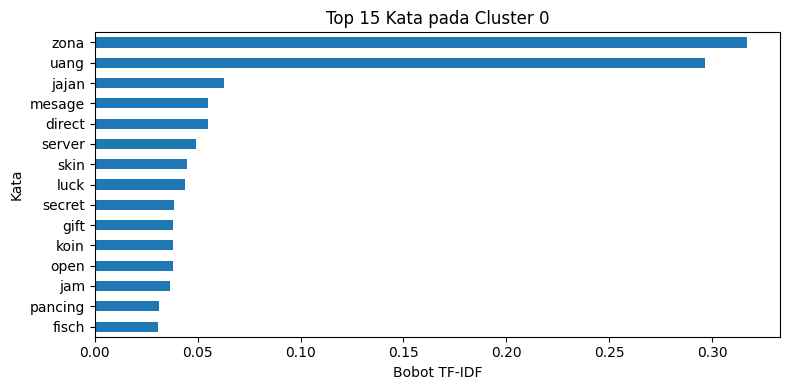

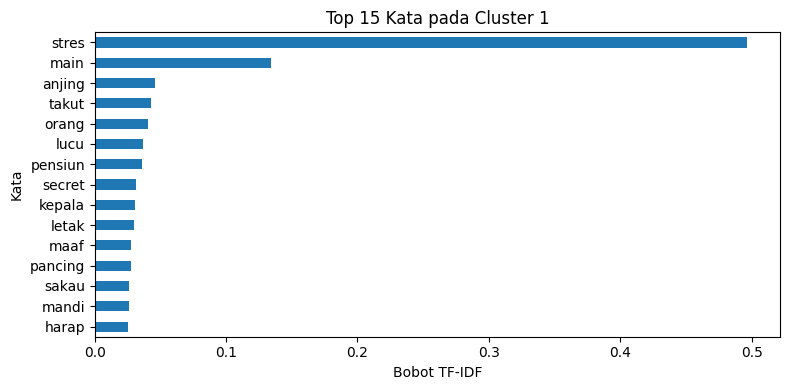

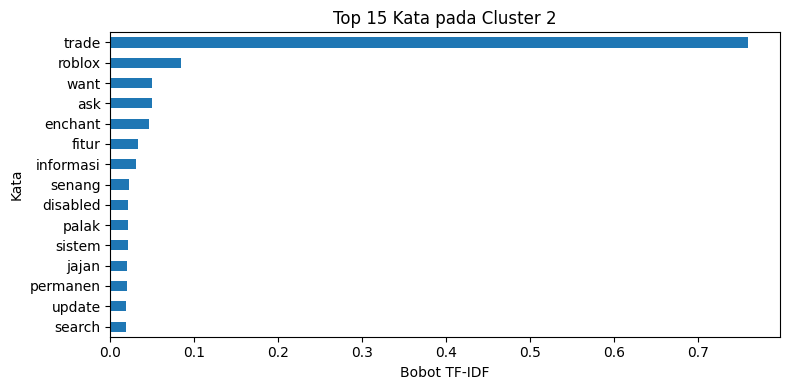

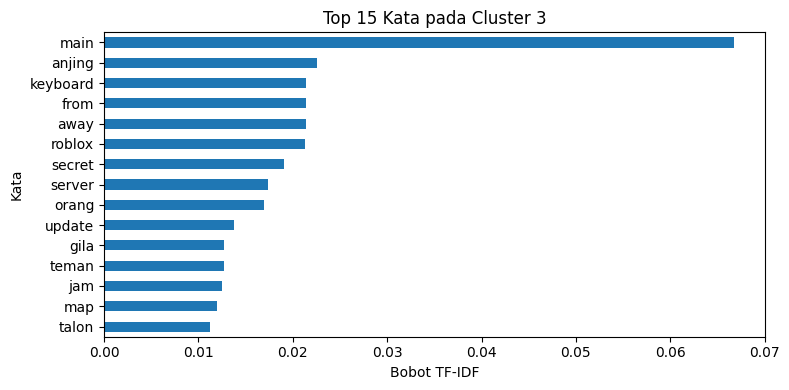

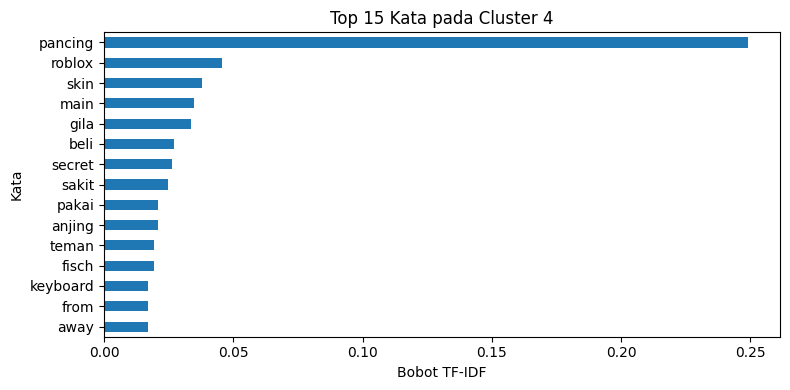

In [143]:
# KMeans dengan K terbaik
kmeans = KMeans(
    n_clusters=best_k,
    random_state=42,
    n_init="auto"
)
df["cluster"] = kmeans.fit_predict(X)

# Top Words per Cluster (Bar Chart)
terms = tfidf.get_feature_names_out()
centroids_df = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=terms
)

print("\n=== TOP WORDS PER CLUSTER ===")

for cluster_id, centroid in centroids_df.iterrows():
    top_words = centroid.nlargest(15)

    plt.figure(figsize=(8, 4))
    top_words.sort_values().plot(kind="barh")
    plt.title(f"Top 15 Kata pada Cluster {cluster_id}")
    plt.xlabel("Bobot TF-IDF")
    plt.ylabel("Kata")
    plt.tight_layout()
    plt.show()


TOPICS (LDA)


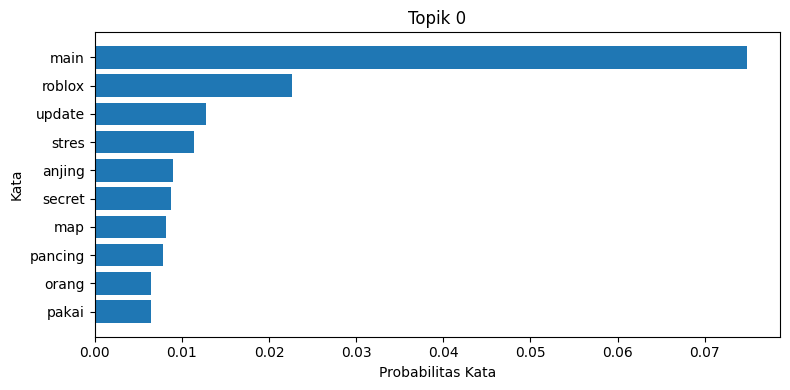

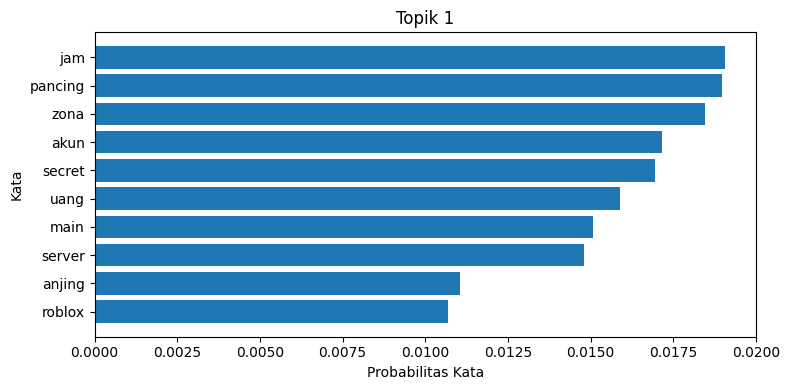

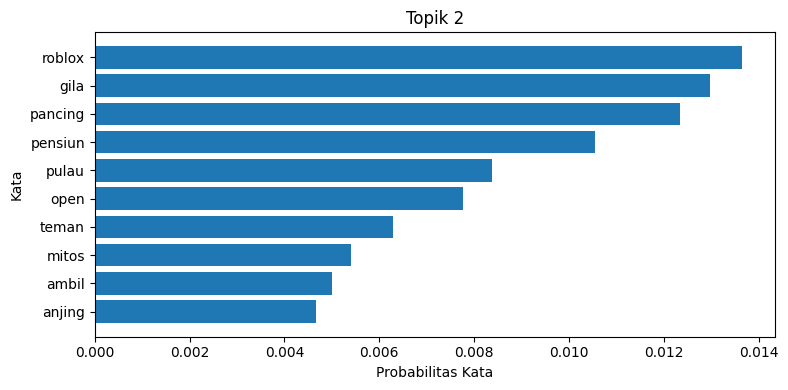

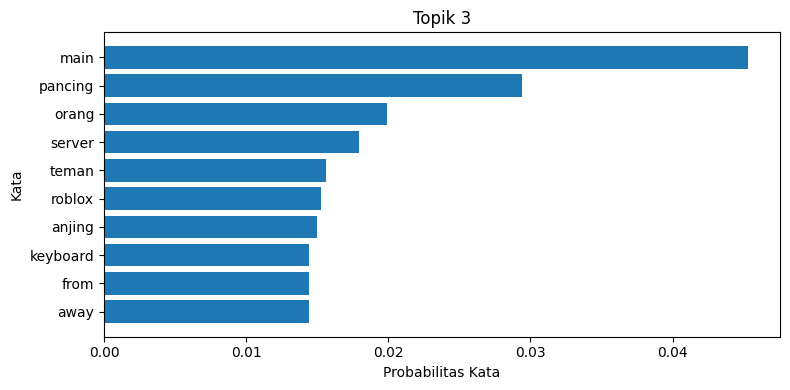

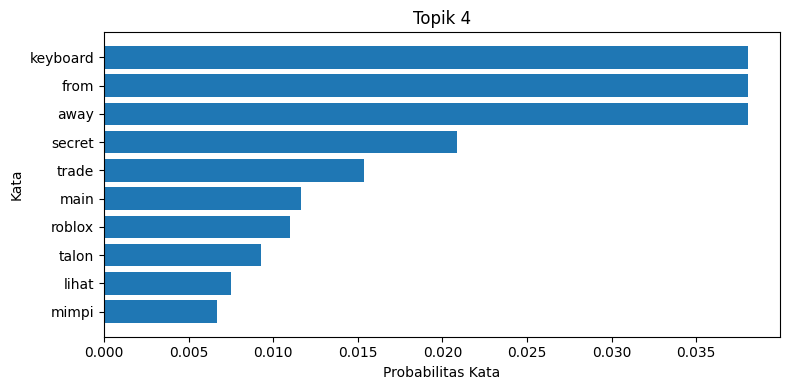

In [144]:
# Persiapan Data LDA
tokens = [t.split() for t in df["bersih"]]

dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(t) for t in tokens]

# Training LDA
lda = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    passes=10,
    random_state=42
)

print("\nTOPICS (LDA)")

# Visualisasi Top Words per Topic (Bar Chart)
for topic_id in range(lda.num_topics):
    topic_terms = lda.show_topic(topic_id, topn=10)

    words = [word for word, prob in topic_terms]
    probs = [prob for word, prob in topic_terms]

    plt.figure(figsize=(8, 4))
    plt.barh(words, probs)
    plt.gca().invert_yaxis()
    plt.title(f"Topik {topic_id}")
    plt.xlabel("Probabilitas Kata")
    plt.ylabel("Kata")
    plt.tight_layout()
    plt.show()

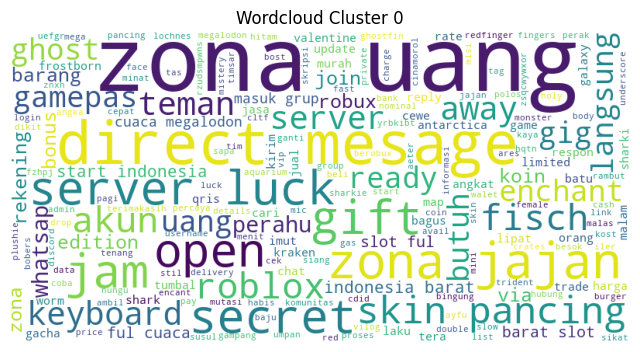

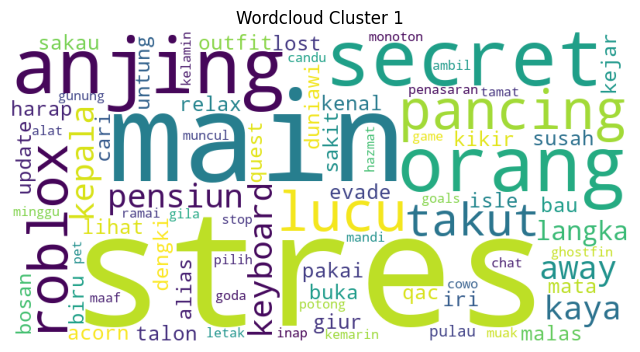

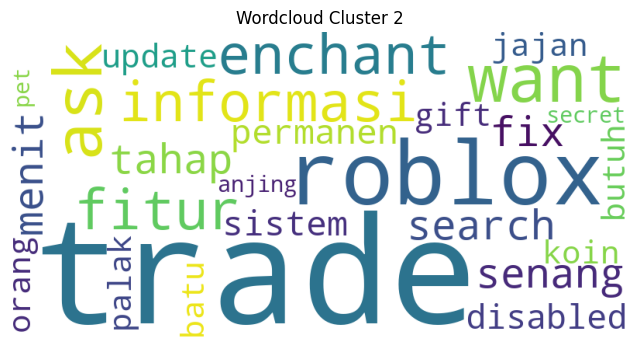

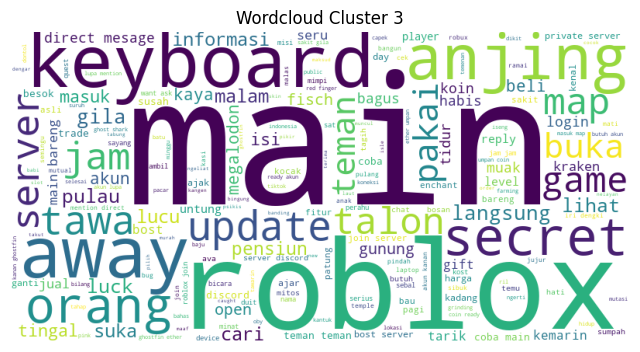

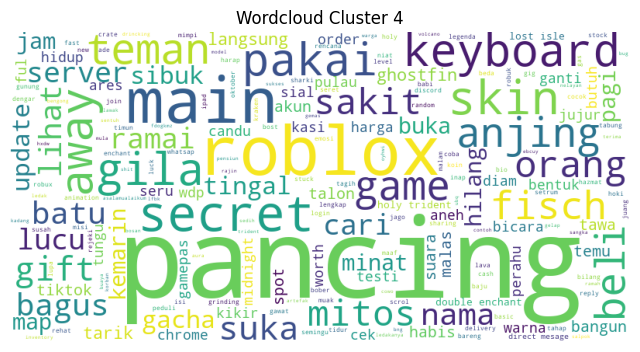

Cluster 5 kosong → dilewati.
Cluster 6 kosong → dilewati.
Cluster 7 kosong → dilewati.
Cluster 8 kosong → dilewati.
Cluster 9 kosong → dilewati.


In [145]:
# Wordcloud per cluster 
for i in range(k):
    text = " ".join(df[df["cluster"] == i]["bersih"])

    if len(text.strip()) == 0:
        print(f"Cluster {i} kosong → dilewati.")
        continue

    plt.figure(figsize=(8, 6))
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate(text)

    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Wordcloud Cluster {i}")
    plt.show()


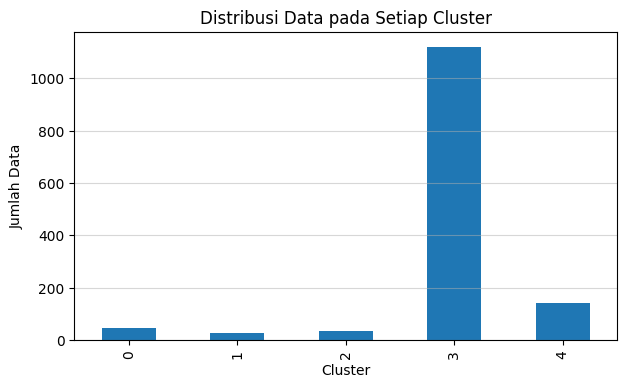

In [146]:
# Distribusi jumlah data tiap cluster
cluster_counts = df["cluster"].value_counts().sort_index()

plt.figure(figsize=(7, 4))
cluster_counts.plot(kind="bar")
plt.title("Distribusi Data pada Setiap Cluster")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Data")
plt.grid(axis="y", alpha=0.5)
plt.show()

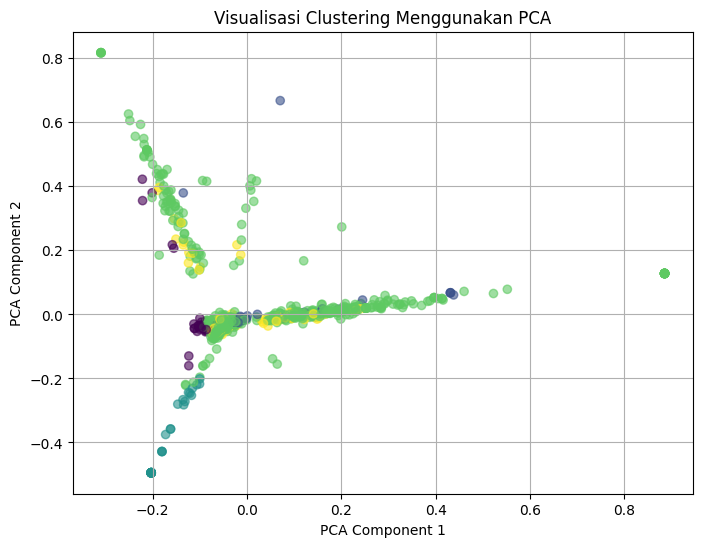

In [147]:
# Reduksi dimensi menggunakan PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df["cluster"],
    alpha=0.6
)
plt.title("Visualisasi Clustering Menggunakan PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()
